In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [501]:
df = pd.read_csv("data/BTC-USD-v2.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [502]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306 entries, 0 to 2305
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2306 non-null   object 
 1   Open       2306 non-null   float64
 2   High       2306 non-null   float64
 3   Low        2306 non-null   float64
 4   Close      2306 non-null   float64
 5   Adj Close  2306 non-null   float64
 6   Volume     2306 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.2+ KB


In [503]:
missing_values = df.isnull().sum()
missing_values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [504]:
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [505]:
df["Date"]

0       2014-09-17
1       2014-09-18
2       2014-09-19
3       2014-09-20
4       2014-09-21
           ...    
2301    2021-01-04
2302    2021-01-05
2303    2021-01-06
2304    2021-01-07
2305    2021-01-08
Name: Date, Length: 2306, dtype: object

In [506]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df["Date"]

0      2014-09-17
1      2014-09-18
2      2014-09-19
3      2014-09-20
4      2014-09-21
          ...    
2301   2021-01-04
2302   2021-01-05
2303   2021-01-06
2304   2021-01-07
2305   2021-01-08
Name: Date, Length: 2306, dtype: datetime64[ns]

In [507]:
df.index = df.pop("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


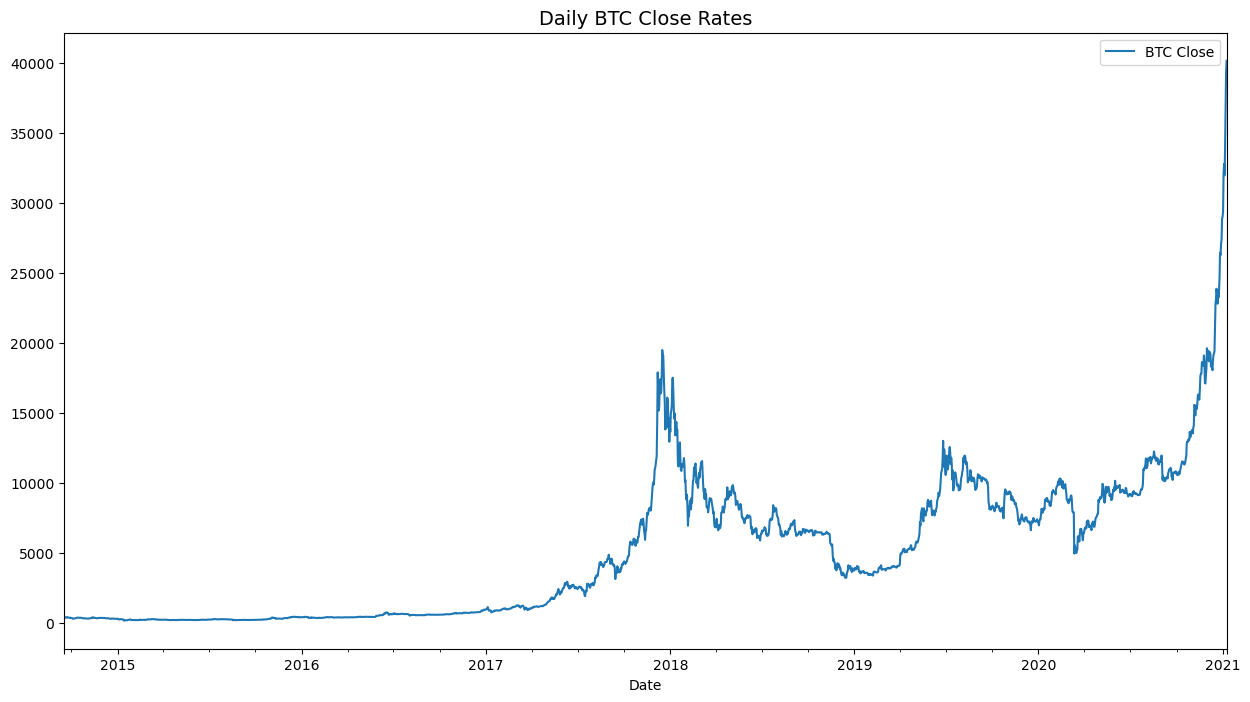

In [508]:
fig = plt.figure(figsize=(15,8))
df.Close.plot(label='BTC Close')
plt.legend(loc='best')
plt.title('Daily BTC Close Rates', fontsize=14)
plt.show()

In [509]:
target = df["Close"].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler.fit_transform(target)
print(target_scaled.shape)

(2306, 1)


In [510]:
train_size = int(len(target_scaled) * 0.6)
train_data, test_data = target_scaled[:train_size], target_scaled[train_size:]
print("train size : {},test size: {}".format(train_data.shape,test_data.shape))

train size : (1383, 1),test size: (923, 1)


In [511]:
train_data

array([[0.00698618],
       [0.00616319],
       [0.00542152],
       ...,
       [0.14324428],
       [0.15112187],
       [0.15576797]])

In [512]:
def create_dataset(data, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(data) - window_size - 1):
        a = data[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(data[i + window_size,0])
    return np.array(data_X), np.array(data_Y)

In [513]:
window_size = 10

X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1372, 10)
y_train:  (1372,)
X_test:  (912, 10)
y_test (912,)


In [514]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1372, 10, 1)
X_test:  (912, 10, 1)


In [494]:
model=Sequential()

model.add(LSTM(30,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

In [495]:
hist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=32,verbose=1)

Epoch 1/150
43/43 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 2/150
43/43 [==============================] - 0s 4ms/step - loss: 5.4582e-04 - val_loss: 4.5173e-04
Epoch 3/150
43/43 [==============================] - 0s 4ms/step - loss: 1.5897e-04 - val_loss: 4.7851e-04
Epoch 4/150
43/43 [==============================] - 0s 4ms/step - loss: 1.5142e-04 - val_loss: 4.9627e-04
Epoch 5/150
43/43 [==============================] - 0s 4ms/step - loss: 1.5581e-04 - val_loss: 5.6009e-04
Epoch 6/150
43/43 [==============================] - 0s 4ms/step - loss: 1.4767e-04 - val_loss: 4.0827e-04
Epoch 7/150
43/43 [==============================] - 0s 4ms/step - loss: 1.5246e-04 - val_loss: 4.1468e-04
Epoch 8/150
43/43 [==============================] - 0s 4ms/step - loss: 1.5121e-04 - val_loss: 3.8103e-04
Epoch 9/150
43/43 [==============================] - 0s 4ms/step - loss: 1.4037e-04 - val_loss: 3.4288e-04
Epoch 10/150
43/43 [=========================

43/43 [==============================] - 0s 4ms/step - loss: 8.1191e-05 - val_loss: 1.6673e-04
Epoch 78/150
43/43 [==============================] - 0s 4ms/step - loss: 7.2268e-05 - val_loss: 1.9034e-04
Epoch 79/150
43/43 [==============================] - 0s 4ms/step - loss: 7.7927e-05 - val_loss: 2.1143e-04
Epoch 80/150
43/43 [==============================] - 0s 4ms/step - loss: 7.4438e-05 - val_loss: 1.5414e-04
Epoch 81/150
43/43 [==============================] - 0s 4ms/step - loss: 7.4881e-05 - val_loss: 1.6395e-04
Epoch 82/150
43/43 [==============================] - 0s 4ms/step - loss: 7.4824e-05 - val_loss: 1.7004e-04
Epoch 83/150
43/43 [==============================] - 0s 4ms/step - loss: 7.5009e-05 - val_loss: 1.5771e-04
Epoch 84/150
43/43 [==============================] - 0s 4ms/step - loss: 7.4383e-05 - val_loss: 5.0715e-04
Epoch 85/150
43/43 [==============================] - 0s 4ms/step - loss: 7.9577e-05 - val_loss: 1.9597e-04
Epoch 86/150
43/43 [=====================

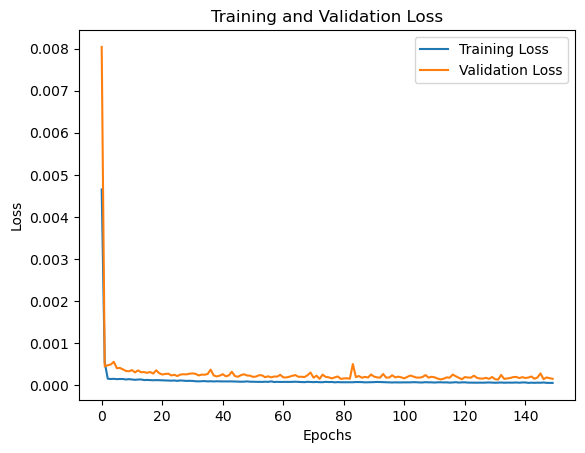

In [496]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [497]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Ölçeklendirme işlemini geri dönüştür
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Eğitim verileri için tahminlerin hatalarını hesapla
train_mse = mean_squared_error(y_train, train_predict)
train_mae = mean_absolute_error(y_train, train_predict)
train_rmse = np.sqrt(train_mse)

print("Training set:")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("RMSE:", train_rmse)

# Test verileri için tahminlerin hatalarını hesapla
test_mse = mean_squared_error(y_test, test_predict)
test_mae = mean_absolute_error(y_test, test_predict)
test_rmse = np.sqrt(test_mse)

print("Test set:")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("RMSE:", test_rmse)


29/29 [==============================] - 0s 1ms/step
Training set:
MSE: 108851.40636476551
MAE: 214.1036372974881
RMSE: 329.9263650646391
Test set:
MSE: 251489.37931240824
MAE: 258.8706846999383
RMSE: 501.4871676448045


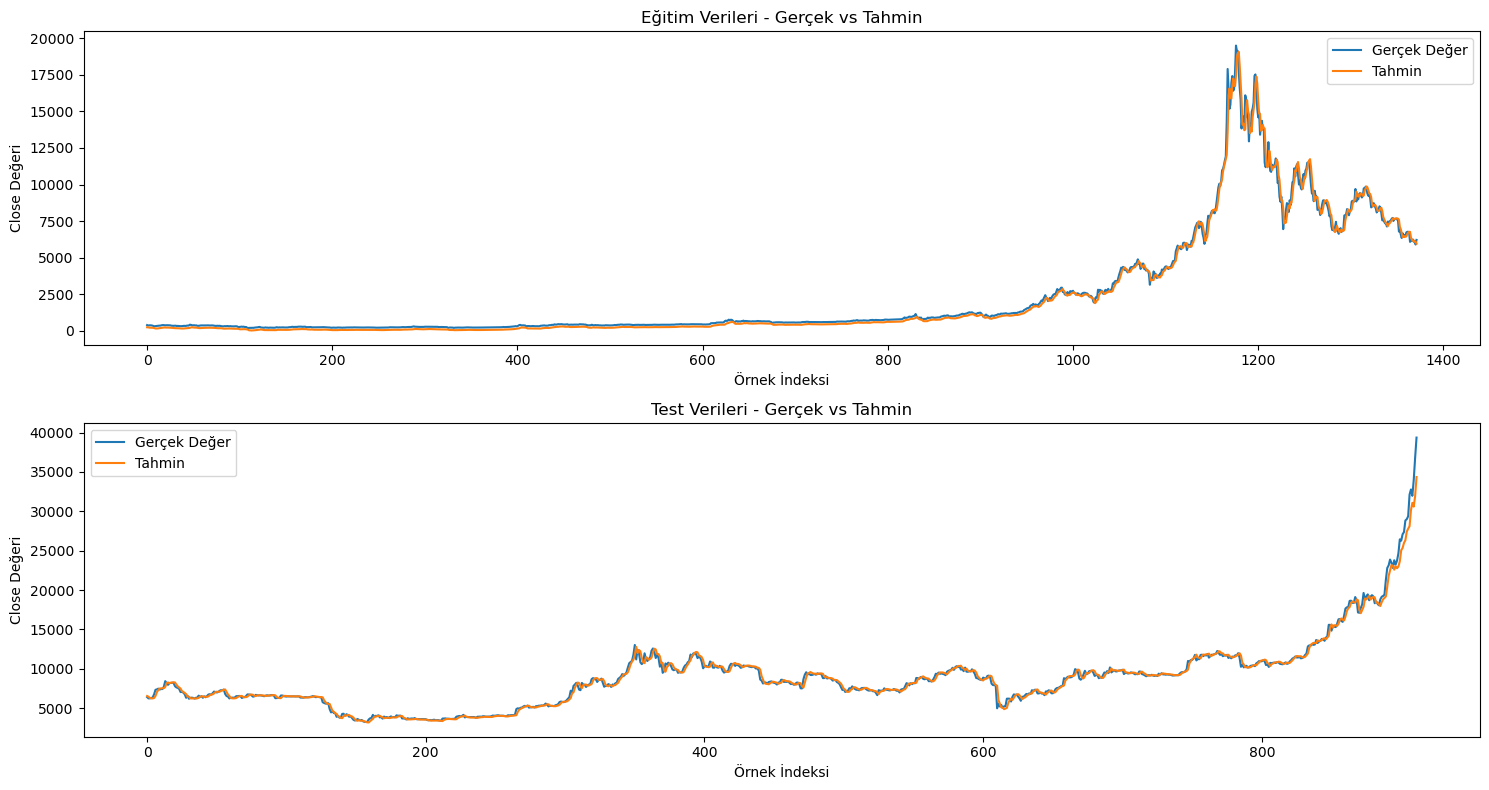

In [498]:
plt.figure(figsize=(15, 8))


plt.subplot(2, 1, 1)
plt.plot(y_train, label='Gerçek Değer')
plt.plot(train_predict, label='Tahmin')
plt.title('Eğitim Verileri - Gerçek vs Tahmin')
plt.xlabel('Örnek İndeksi')
plt.ylabel('Close Değeri')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(y_test, label='Gerçek Değer')
plt.plot(test_predict, label='Tahmin')
plt.title('Test Verileri - Gerçek vs Tahmin')
plt.xlabel('Örnek İndeksi')
plt.ylabel('Close Değeri')
plt.legend()

plt.tight_layout()
plt.show()

GRU

In [515]:
gruModel = Sequential()

gruModel.add(GRU(30,return_sequences=True,input_shape=(X_train.shape[1],1)))
gruModel.add(Dropout(0.25))
gruModel.add(GRU(30))
gruModel.add(Dropout(0.25))

gruModel.add(Dense(1))
gruModel.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 10, 30)            2970      
                                                                 
 dropout_17 (Dropout)        (None, 10, 30)            0         
                                                                 
 gru_20 (GRU)                (None, 30)                5580      
                                                                 
 dropout_18 (Dropout)        (None, 30)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 31        
                                                                 
Total params: 8,581
Trainable params: 8,581
Non-trainable params: 0
_________________________________________________________________


In [516]:
gruModel.compile(optimizer="adam",loss="mean_squared_error")
gruModel.fit(X_train,y_train,validation_data=(X_test, y_test), epochs=150, batch_size=32, verbose=1)

Epoch 1/150
43/43 [==============================] - 5s 20ms/step - loss: 0.0024 - val_loss: 4.4173e-04
Epoch 2/150
43/43 [==============================] - 0s 7ms/step - loss: 4.1165e-04 - val_loss: 8.6280e-04
Epoch 3/150
43/43 [==============================] - 0s 7ms/step - loss: 5.1436e-04 - val_loss: 3.4043e-04
Epoch 4/150
43/43 [==============================] - 0s 7ms/step - loss: 3.3270e-04 - val_loss: 6.3954e-04
Epoch 5/150
43/43 [==============================] - 0s 7ms/step - loss: 3.9169e-04 - val_loss: 2.9543e-04
Epoch 6/150
43/43 [==============================] - 0s 7ms/step - loss: 3.8412e-04 - val_loss: 4.0250e-04
Epoch 7/150
43/43 [==============================] - 0s 7ms/step - loss: 3.4100e-04 - val_loss: 2.5399e-04
Epoch 8/150
43/43 [==============================] - 0s 7ms/step - loss: 3.2788e-04 - val_loss: 2.8833e-04
Epoch 9/150
43/43 [==============================] - 0s 7ms/step - loss: 2.4712e-04 - val_loss: 2.9050e-04
Epoch 10/150
43/43 [====================

Epoch 77/150
43/43 [==============================] - 0s 7ms/step - loss: 2.4422e-04 - val_loss: 2.1542e-04
Epoch 78/150
43/43 [==============================] - 0s 7ms/step - loss: 2.4193e-04 - val_loss: 3.1387e-04
Epoch 79/150
43/43 [==============================] - 0s 7ms/step - loss: 2.4605e-04 - val_loss: 2.6102e-04
Epoch 80/150
43/43 [==============================] - 0s 7ms/step - loss: 2.9638e-04 - val_loss: 2.2431e-04
Epoch 81/150
43/43 [==============================] - 0s 7ms/step - loss: 2.0195e-04 - val_loss: 1.9208e-04
Epoch 82/150
43/43 [==============================] - 0s 7ms/step - loss: 2.1565e-04 - val_loss: 2.5388e-04
Epoch 83/150
43/43 [==============================] - 0s 7ms/step - loss: 2.1774e-04 - val_loss: 1.8628e-04
Epoch 84/150
43/43 [==============================] - 0s 7ms/step - loss: 1.8692e-04 - val_loss: 3.4209e-04
Epoch 85/150
43/43 [==============================] - 0s 7ms/step - loss: 1.9898e-04 - val_loss: 3.7751e-04
Epoch 86/150
43/43 [========

29/29 [==============================] - 0s 2ms/step


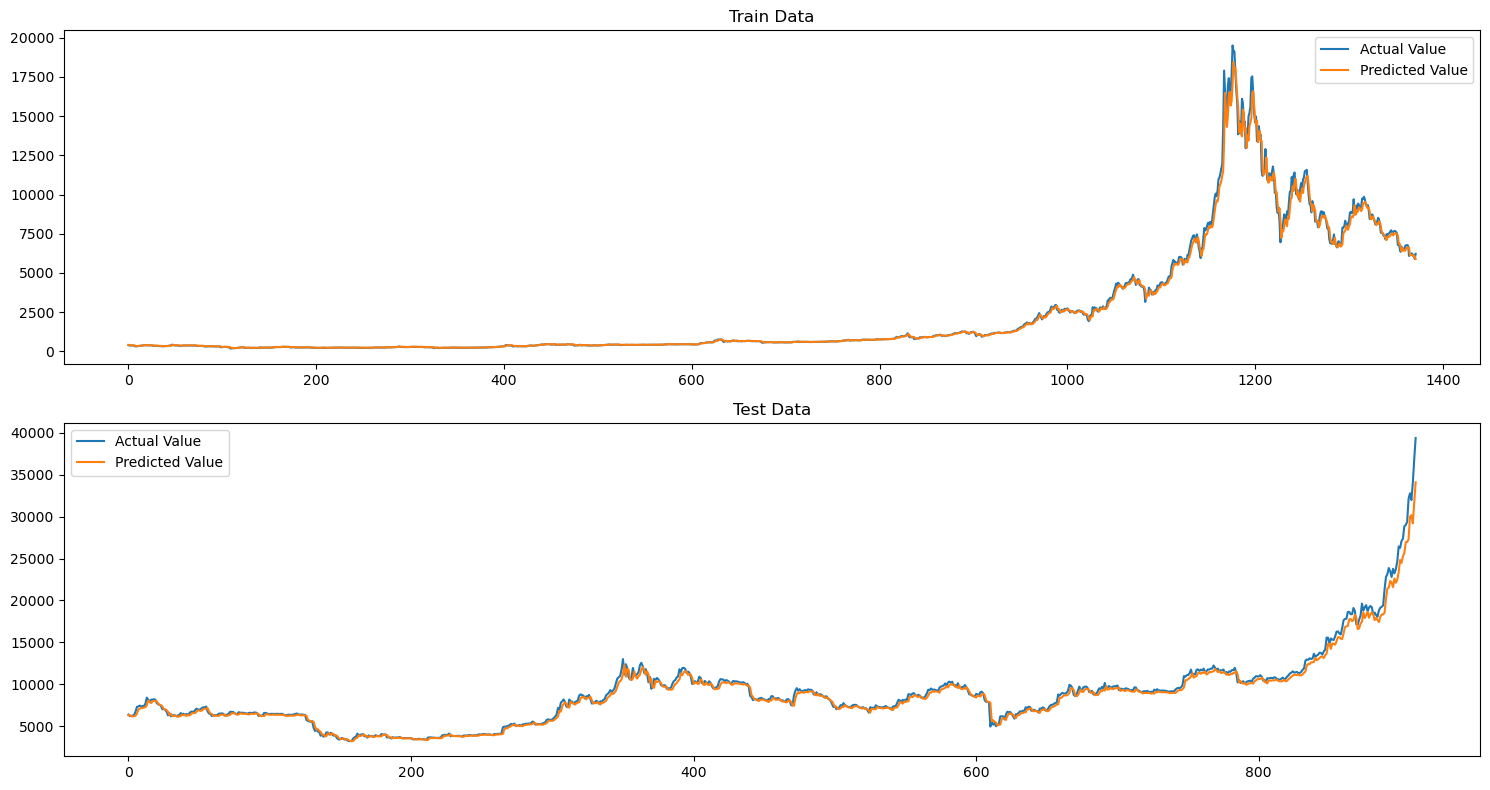

Train Set:
RMSE:  309.4894499452589
MSE:  95783.71962741893
MAE:  112.49888687798662

Test Set:
RMSE:  614.2792893866429
MSE:  377339.04536935897
MAE:  340.3291256508361


In [517]:
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    return rmse, mse, mae


train_predict = gruModel.predict(X_train)
test_predict = gruModel.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

train_rmse, train_mse, train_mae = calculate_metrics(y_train[0], train_predict[:, 0])
test_rmse, test_mse, test_mae = calculate_metrics(y_test[0], test_predict[:, 0])

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(y_train[0], label='Actual Value')
plt.plot(train_predict[:, 0], label='Predicted Value')
plt.title('Train Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y_test[0], label='Actual Value')
plt.plot(test_predict[:, 0], label='Predicted Value')
plt.title('Test Data')
plt.legend()

plt.tight_layout()
plt.show()

print("Train Set:")
print("RMSE: ", train_rmse)
print("MSE: ", train_mse)
print("MAE: ", train_mae)

print("\nTest Set:")
print("RMSE: ", test_rmse)
print("MSE: ", test_mse)
print("MAE: ", test_mae)